In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
import pandas as pd
import numpy as np
import cohorts
from cohorts.functions import missense_snv_count, snv_count
import query_tcga
from query_tcga import config, samples
config.load_config('config.ini')
import logging
logging.basicConfig(level=logging.DEBUG)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/jacquelineburos/anaconda3/envs/python27/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Creating a Cohort

There are several ways to create a Cohort using [cohorts](http://github.com/hammerlab/cohorts).

In our first example, we [created a Cohort from clinical data](http://github.com/jburos/tcga-blca/blob/master/Part%20I%20-%20Creating%20a%20cohort%20from%20clinical%20data%20using%20python2.ipynb). We also showed several of the data summary methods available, using clinical covariates as exampes. 

But the true value of Cohorts lies in its ability to summarize various categories of genetic & molecular data and to incorporate those data into the analysis.

For example, we are going to again use `TCGA` data from the `BLCA` cohort (generated using the `get_clinical_data.py` command-line script available here). 


## Part 2: Creating a Cohort with somatic mutations

### download VCF files

To create the `Patient` object, we just need to know the path to the VCF file. 

There is a helper script in this repo called `refresh_vcf_data.py`. This script downloads VCF files for this project to the `GDC_DATA_DIR`, and stores a delimited version of the fileinfo in the `data` directory.

To run the script, you would type the following:

    python refresh_vcf_data.py

Once this has completed, we only have to map each VCF file to the corresponding patient_id.

In [40]:
all_vcf_files = pd.read_csv('data/vcf_fileinfo.csv', sep='|')
vcf_fileinfo = all_vcf_files.loc[:,['submitter_id','filepath']]
vcf_fileinfo.rename(columns = {'filepath': 'snv_vcf_paths'}, inplace=True)
vcf_fileinfo['patient_id'] = vcf_fileinfo['submitter_id'].apply(lambda x: x.split('-')[2])
vcf_fileinfo.head()

,submitter_id,snv_vcf_paths,patient_id
0,TCGA-XF-AAN4,data/gdc/03af9a12-e78e-4d5e-8bfe-eed1168e481c/...,AAN4
1,TCGA-XF-AAML,data/gdc/05b3d9a5-9414-4aa8-899b-243ee07d7231/...,AAML
2,TCGA-E7-A541,data/gdc/0193bf32-cb0a-419d-a18c-e37ae2747eba/...,A541
3,TCGA-XF-AAMH,data/gdc/06f5a911-6cab-4b31-8daa-86830972b1c5/...,AAMH
4,TCGA-BT-A2LA,data/gdc/0952e72a-2f04-42fc-bd46-f0378d3f7622/...,A2LA


In [48]:
vcf_fileinfo['snv_vcf_paths'] = vcf_fileinfo['snv_vcf_paths'].apply(query_tcga.helpers.convert_to_list)
vcf_fileinfo.head()
vcf_fileinfo_agg = vcf_fileinfo.groupby('patient_id').agg({'snv_vcf_paths': 'sum'}).reset_index()
vcf_fileinfo_agg.head()
#all_vcf_files.loc[all_vcf_files.duplicated('submitter_id'),:]

,patient_id,snv_vcf_paths
0,A0C8,[data/gdc/1db7cb30-c1de-43d4-831a-2b1ce399b51a...
1,A0F0,[data/gdc/ea66441b-e846-47cd-8150-235ddbf0a8d5...
2,A0F6,[data/gdc/995553e6-9f56-4989-b774-640e728405fa...
3,A0F7,[data/gdc/7883ff0d-7b54-4716-a22c-d1589beaf220...
4,A13I,[data/gdc/98d75d71-de58-4105-bdbc-9ef40dd815f6...


### load clinical data 

Here, we will modify the `prep_patient_data` code we used in our earlier script to include processing the extra parameter: `snv_vcf_paths`. 

In practice, we would include this code in a utility script (we typically name this `analysis/utils/data.py`) so that it can be easily reused, but for this exercise we will code this manually.

In [49]:
clinical_data = pd.read_csv('data/clinical.csv', sep='|')
clinical_data = clinical_data.merge(vcf_fileinfo_agg, on='patient_id', how='left')
assert clinical_data['snv_vcf_paths'].count()>0
clinical_data.dropna(subset=['snv_vcf_paths'], inplace=True, axis=0)
assert clinical_data.duplicated('patient_id').any() == False, 'Duplicates by patient_id'

In [63]:
def prep_patient_data(row):
    # capture key outcome data elements
    patient_id = row['patient_id']
    deceased = row['vital_status'] != 'Alive'
    progressed = row['treatment_outcome_at_tcga_followup'] != 'Complete Response'
    censor_time = float(row['last_contact_days_to'])
    deceased_time = float(row['death_days_to'])
    progressed_time = float(row['new_tumor_event_dx_days_to'])
    
    # compute age at diagnosis
    row['age'] = (-1*row['birth_days_to'])/365.25
    
    # save back in 'row' as-is so that we can see raw values
    row['progressed_time'] = progressed_time
    row['deceased_time'] = deceased_time
    row['censor_time'] = censor_time
    row['progressed'] = progressed
    row['deceased'] = deceased

    # clean up censor time - a number of obs have NaN values 
    if np.isnan(censor_time):
        censor_time = max(progressed_time, deceased_time, censor_time)
    if censor_time > progressed_time:
        censor_time = progressed_time
    if censor_time > deceased_time:
        censor_time = deceased_time

    # save time-to-event-or-censor data elements
    os = deceased_time if deceased else censor_time
    pfs = progressed_time if progressed else os
    
    # again, make sure outcomes aren't NaN
    if np.isnan(os):
        os = censor_time

    if np.isnan(pfs):
        pfs = os
    
    # save transformed versions of outcome back to 'row' object for inspection
    row['pfs'] = pfs
    row['os'] = os
    row['censor_time'] = censor_time
    
    # force progressed time to be < os 
    pfs = min(pfs, os) 
    
    # definition of benefit for this cohort
    benefit = pfs <= 365.25
    
    # these conditions are required by Cohorts
    assert(not np.isnan(pfs))
    assert(not np.isnan(os))
    assert pfs <= os, 'PFS {pfs} is not <= OS {os} for Patient {patid}'.format(pfs=pfs, os=os, patid=patient_id)
    
    # capture snv_vcf_paths, if they exist
    if 'snv_vcf_paths' in row.keys() and isinstance(row['snv_vcf_paths'], list):
        snv_vcf_paths = query_tcga.helpers.convert_to_list(row['snv_vcf_paths'])
    else:
        snv_vcf_paths = None
    
    # create our patient object
    patient = cohorts.Patient(
        id=str(patient_id),
        deceased=deceased,
        progressed=progressed,
        os=os,
        pfs=pfs,
        benefit=benefit,
        additional_data=row,
        snv_vcf_paths=snv_vcf_paths,
    )
    return(patient)


As in the earlier example, we will process the rows of our clinical data into a list of Patients

In [64]:
patients = []
for (i, row) in clinical_data.iterrows():
    patients.append(prep_patient_data(row))

And, create a Cohort object from the list

In [65]:
blca_cohort2 = cohorts.Cohort(patients, cache_dir='data-cache2')

{'dataframe_hash': 7427154331580444848,
 'provenance_file_summary': {u'cohorts': u'0.2.0+6.g205397b',
                             u'isovar': u'0.0.6',
                             u'mhctools': u'0.2.3',
                             u'numpy': u'1.11.1',
                             u'pandas': u'0.18.1',
                             u'pyensembl': u'0.9.7',
                             u'scipy': u'0.17.1',
                             u'topiary': u'0.0.21',
                             u'varcode': u'0.4.14'}}


## plot survival

As before, we can plot survival for this cohort. 

This time, however, instead of passing the name of a field in our dataframe, we will pass a function which summarizes the variants (VCFs) for this patient. 

# no condition 71
# with condition 70


<lifelines.StatisticalResult: 
Results
   df: 1
   alpha: 0.95
   t 0: -1
   test: logrank
   null distribution: chi squared

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.19330 |              1.692 |  Cannot Reject Null |       False       
>

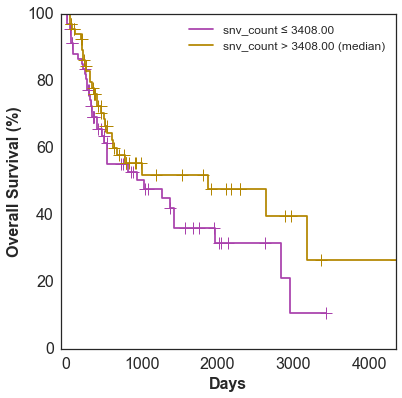

In [67]:
blca_cohort2.plot_survival(on=cohorts.functions.snv_count)

This is not dissimilar from the `high_grade_tumor` function we created in the earlier example:

In [68]:
def high_grade_tumor(row):
    return row['tumor_grade'] == 'High Grade'

However, this function is a little more intricate. 

Let's look, for example, at the `snv_count` function ([as of v0.2.0](https://github.com/hammerlab/cohorts/blob/0.2.0/cohorts/functions.py#L24-L38)):

In [74]:
def alt_snv_count(row, cohort, filter_fn=None, normalized_per_mb=None, **kwargs):
    filter_fn = first_not_none_param([filter_fn, cohort.filter_fn], no_filter)
    normalized_per_mb = first_not_none_param([normalized_per_mb, cohort.normalized_per_mb], False)
    patient_id = row["patient_id"]
    patient_variants = cohort.load_variants(
        patients=[cohort.patient_from_id(patient_id)],
        filter_fn=filter_fn,
        **kwargs)
    if patient_id in patient_variants:
        count = len(patient_variants[patient_id])
        if normalized_per_mb:
            count /= float(get_patient_to_mb(cohort)[patient_id])
        return count
    return np.nan


There are essentially three steps to this function, other than processing input params:
1. Identify the patient, given the row
2. Load variants for this patient (compute them, or load from cache using the union of VCFs).
    - Optionally apply any QC filters defined at Cohort or function level (more on this to come)
3. Count the variants associated with this patient

## recreate snv_count for one patient

If we were to recreate these steps semi-manually, they would look something like the following:

In [69]:
row = blca_cohort2.as_dataframe().iloc[0,:]
filter_fn = cohorts.variant_filters.no_filter
patient_id = row['patient_id']

In [70]:
patient_variants = blca_cohort2.load_variants(patients=[blca_cohort2.patient_from_id(patient_id)], filter_fn=filter_fn)

In [71]:
count = len(patient_variants[patient_id])

In [72]:
count

3679

## plot snv_count by benefit

Mann-Whitney test: U=2337.0, p-value=0.643264297939 (two-sided)


MannWhitneyResults(U=2337.0, p_value=0.643264297939, sided_str='two-sided')

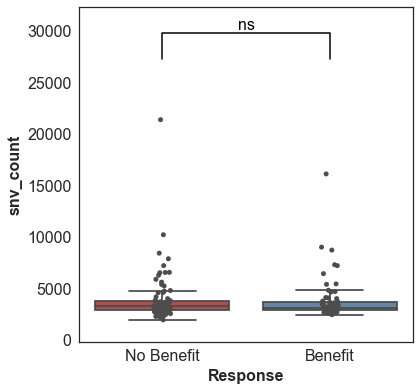

In [73]:
blca_cohort2.plot_benefit(cohorts.functions.snv_count)

## retrieve dataframe for a cohort

As before, we can retrieve the same summary statistics as a dataframe. 

Here it is possible to provide a list of functions so that multiple summary statistics can be computed in the same dataframe.

Also note that **the function now returns a tuple** when a list is passed to the parameter `on`. 
    (By comparison, when no `on` parameter is given, `as_dataframe()` simply returns a dataframe.)

In [44]:
extra_cols, df = blca_cohort2.as_dataframe(on=[cohorts.functions.snv_count])
print(extra_cols)

['snv_count']


## cached effects

There's a fair amount of processing required to load the VCFs into varcode & summarize patient effects. 

To speed up this process, `Cohorts` caches intermediate results of these computations on the filesystem.

We now have a new folder in our `data-cache` directory:

In [45]:
ls -1 data-cache2/

cached-variants/


Within that directory, we have one folder per patient containing cached variants:

In [46]:
ls -1 data-cache2/cached-variants/ | head

A0S7/
A1AB/
A2LA/
A2OE/
A2PC/
A3I6/
A3IV/
A3MH/
A3SL/
A3WX/


We can also now check our data-source summary to ensure that all cached data were prepared in the same environment.

In [47]:
blca_cohort2.summarize_data_sources()

{'dataframe_hash': 463748958046215442,
 'provenance_file_summary': {u'cohorts': u'0.2.0+6.g205397b',
  u'isovar': u'0.0.6',
  u'mhctools': u'0.2.3',
  u'numpy': u'1.11.1',
  u'pandas': u'0.18.1',
  u'pyensembl': u'0.9.7',
  u'scipy': u'0.17.1',
  u'topiary': u'0.0.21',
  u'varcode': u'0.4.14'}}

The next time these data are used, the provenance_file_summary will be updated.

## Summary and next steps

We can now start to see some of the utility of `Cohorts` for managing clinical + somatic mutation data.

But, there is more to come. 

Next up: advanced features (filters) & the dataframe_loader 
